In [358]:
import sys
import statistics
import math
import pyaudio
import aubio
import numpy as np
import matplotlib.pyplot as plt
#from demo_waveform_plot import get_waveform_plot, set_xlabels_sample2time

In [359]:
filename = "../samples/london.wav"

In [360]:
SAMPLE_RATE = 44100
WINDOW_SIZE = 4096 # fft size
HOP_SIZE = 1024 # hop size
TOLERANCE = 0.8

In [361]:
methods = ['yinfft', 'schmitt', 'fcomb', 'mcomb', 'yin']

In [362]:
pitches = {}
confidences = {}
times = {}
for method in methods:
    pitches[method] = []
    confidences[method] = []
    times[method] = []

In [363]:
for method in methods:
    s = aubio.source(filename, SAMPLE_RATE, HOP_SIZE)
    pitch_o = aubio.pitch(method, WINDOW_SIZE, HOP_SIZE, SAMPLE_RATE)
    pitch_o.set_unit("Hz")
    pitch_o.set_tolerance(TOLERANCE)
    # total number of frames read
    total_frames = 0
    while True:
        samples, read = s()
        pitch = pitch_o(samples)[0]
        #pitch = int(round(pitch))
        confidence = pitch_o.get_confidence()
        #if confidence < 0.8: pitch = 0.
        #print("%f %f %f" % (total_frames / float(samplerate), pitch, confidence))
        pitches[method] += [pitch]
        confidences[method] += [confidence]
        total_frames += read
        if read < HOP_SIZE: 
            print("read %s frames with method %s" % (total_frames, method))
            break    

read 246623 frames with method yinfft
read 246623 frames with method schmitt
read 246623 frames with method fcomb
read 246623 frames with method mcomb
read 246623 frames with method yin


In [364]:
for method in methods:
    pitches[method] = np.array(pitches[method])
    confidences[method] = np.array(confidences[method])
    times[method] = [t * HOP_SIZE for t in range(len(pitches[method]))]

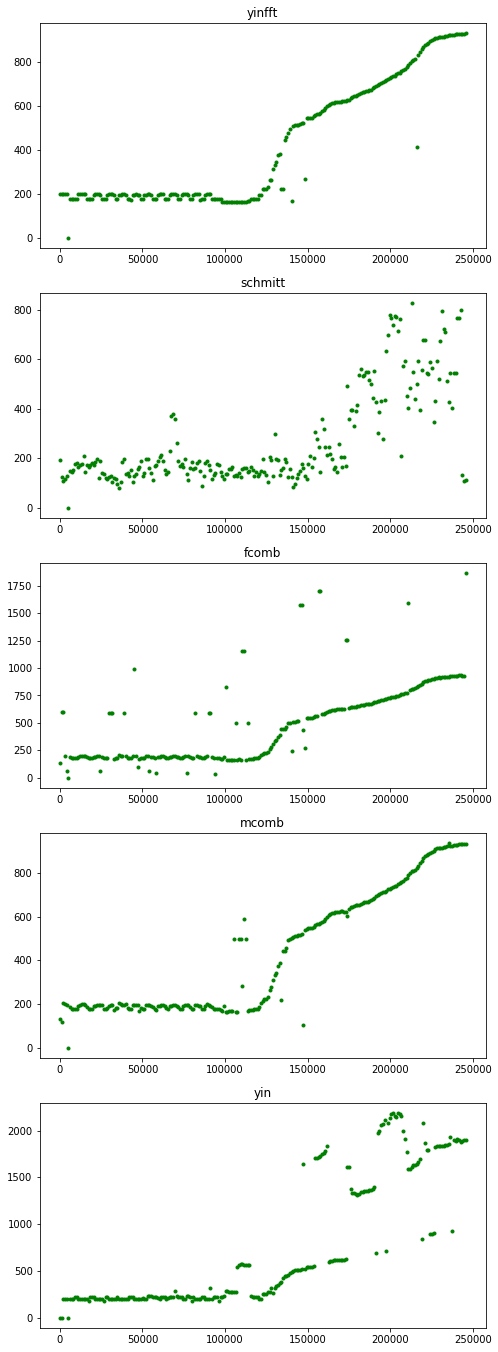

In [365]:
fig = plt.figure(figsize=(8, 24))
for m,method in enumerate(methods):
    ax = fig.add_subplot(len(methods), 1, m+1)
    ax.plot(times[method], pitches[method], '.g')
    plt.title(method)

In [366]:
preferred_methods = ["yinfft", "fcomb", "mcomb"]

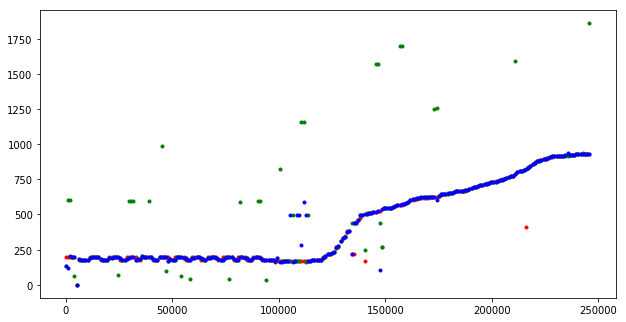

In [367]:
colors = ['red', 'green', 'blue']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])

for m,method in enumerate(preferred_methods):
    ax.plot(times[method], pitches[method], '.g', color=colors[m])

In [368]:
medians = []
for i in range(len(pitches["mcomb"])):
    hz = [ int(pitches[method][i]) for method in preferred_methods ]
    medians += [statistics.median(hz)]

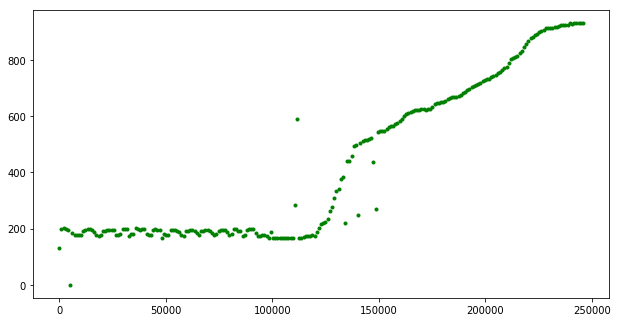

In [369]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.plot(times["mcomb"], medians, '.g')

In [370]:
arr = pitches["yinfft"]
print(len(arr))

corrected = [arr[0]]
for i in range(1, len(arr)):
    diff = abs(arr[i]-corrected[i-1])
    if diff > 50:
        average = (corrected[i-1] + arr[i+1]) / 2
        print(1, i, arr[i], corrected[i-1], diff, average)
        corrected += [average]
    else:
        corrected += [arr[i]]
        
for x in range(2,10):
    arr = corrected
    for i in range(1, len(arr)-1):
        diff = (abs(arr[i]-arr[i-1]) + abs(arr[i] - arr[i+1])) / 2
        if diff > (50 - 2 * x) * (len(corrected) - i) / len(corrected):
            average = (arr[i-1] + arr[i+1]) / 2
            print(x, i, arr[i], corrected[i-1], diff, average)
            corrected[i] = average

241
1 5 0.0 198.58585 198.58585 187.43150329589844
1 131 221.32492 384.2699 162.94498 302.60247802734375
1 132 220.93504 302.60247802734375 81.66743469238281 373.79534912109375
1 133 444.98822 373.79534912109375 71.19287109375 417.45147705078125
1 137 167.82558 494.24084 326.41528 501.656982421875
1 145 270.50836 526.00195 255.49359 535.3875732421875
1 211 412.85815 815.79877 402.9406 824.673095703125
2 125 265.43652 262.84198 25.650848388671875 288.4928283691406
2 128 345.02933 332.20303 23.459686279296875 355.6627197265625
2 130 384.2699 379.1224 43.40745544433594 340.86244201660156
2 131 302.60247802734375 340.86244201660156 54.726417541503906 357.32889556884766
2 132 373.79534912109375 357.32889556884766 30.061290740966797 387.39018630981445
2 133 417.45147705078125 387.39018630981445 36.85870933532715 424.2488956451416
2 134 461.1076 424.2488956451416 25.97865581512451 450.2275514602661
2 135 476.2062 450.2275514602661 22.006646633148193 472.2341980934143
2 205 777.42773 771.0285 

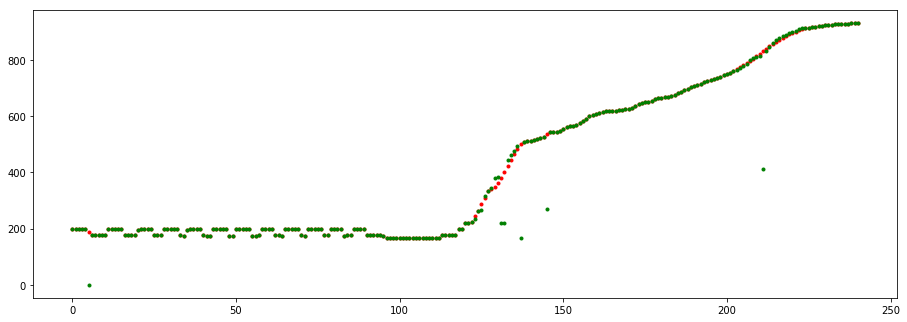

In [371]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_axes([0,0,1,1])
ax.plot(corrected, '.g', color="red")
ax.plot(pitches["yinfft"], '.g', color="green")